# Data preparation and transformation exercise

## Part IV - Correlated features and outliers

The objective of this exercise is to practice various steps of data preprocessing and feature engineering.

The scenario is the preparation of data for a ML multilinear regressions.

The dataset used is the "Climate Weather Surface of Brazil - Hourly", wich is available at <a href="https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region?select=make_dataset.py">Kaggle</a>.

It contains hourly climate data taken from 122 weather stations in Brasil between 2000 and 2021.

**Steps:**

1. Load data
2. Inspect data
3. Format features
4. Clean messy data
5. Remove duplicate values
6. Treat missing values
7. Imputation
8. <a href="#Remove-strongly-correlated-features">Remove strongly correlated features</a>
9. <a href="#Remove-outliers">Remove outliers</a>
10. Aggregate features
11. Encode categorical features
12. Feature scaling
13. Dimensionality reduction and feature decomposition
14. Sample and balance

## Remove strongly correlated features

In [51]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
pickle.dump(dataset, open("imputed_dataset.pkl", "wb"))

To check for correlation we will use data from the oldest weather station, with ID

In [32]:
oldest_station = dataset.loc[dataset.full_time.dt.year == 2000, "station_name"].unique()[0]
oldest_station

'BRASILIA'

In [33]:
oldest_station_data = dataset.loc[dataset.station_name == oldest_station]

In [34]:
station_numeric_features = oldest_station_data.iloc[:,1:17].copy()
station_numeric_features.head()

,precipitation,pressure,pressure_max,pressure_min,solar_radiation,air_temperature,dp_temperature,air_temp_max,air_temp_min,dp_temp_max,dp_temp_min,rel_hum_max,rel_hum_min,Rel_humidity,wind_direction,wind_gust
919803,0.0,887.8,887.8,887.1,1710.329741,21.8,18.0,21.8,21.6,18.2,17.7,81.0,78.0,79.0,117.0,4.0
919804,0.0,888.2,888.3,887.8,1710.329741,21.8,17.9,21.9,21.5,18.5,17.9,83.0,78.0,79.0,135.0,2.8
919805,0.0,888.5,888.5,888.2,1710.329741,20.8,17.8,21.8,20.8,18.1,17.7,83.0,78.0,83.0,131.0,2.1
919806,0.0,888.1,888.6,888.1,1710.329741,21.2,17.9,21.3,20.5,18.2,17.8,85.0,81.0,81.0,120.0,2.8
919807,0.0,887.4,888.1,887.4,1710.329741,20.9,17.4,21.2,20.7,18.2,17.4,84.0,81.0,81.0,133.0,2.8


<AxesSubplot:>

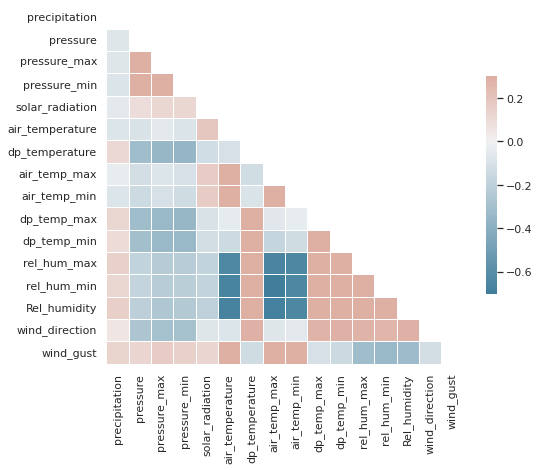

In [35]:
sns.set_theme(style="white")

corr = station_numeric_features.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 8))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There's a moderate relation between these features:
- air_temperature
- rel_hum_max
- rel_hum_min
- Rel_humidity

The correlation is not very high, but for the purpose of this exercise we'll treat them as if it was high, and, in order to avoid multicollinearity when using the data for multiple linear regression, we'll drop the relative humidity features from the dataset.

In [36]:
dataset.drop(columns = ['rel_hum_min', 'rel_hum_max', 'Rel_humidity'], inplace=True)

In [37]:
pickle.dump(dataset, open("weak_correlation_dataset.pkl", "wb"))

## Remove outliers

Let's look at a single feature, to identify if there are any outliers (observations that are distant from the other observations).

<AxesSubplot:xlabel='air_temperature'>

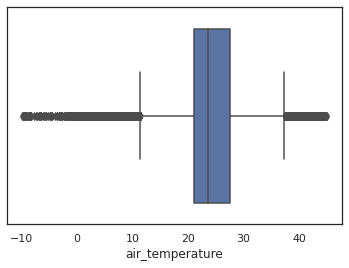

In [38]:
sns.boxplot(x=dataset['air_temperature'])

Clearly there are many outliers, but what is an outlier in one station may be a frequent value in another.

Let's look at the PDF of this feature.

<AxesSubplot:ylabel='Density'>

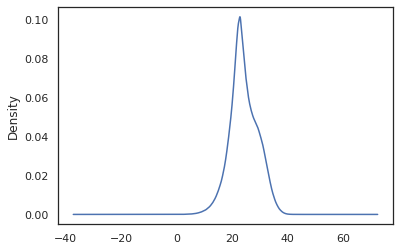

In [39]:
dataset.air_temperature.plot.kde();

Let's boxplot all features for three randomly picked stations, to observe if outliers fall in similar ranges between stations.

In [40]:
# array with station names
stations = dataset.station_name.unique()

# fix random state for repeatability
np.random.seed(321)

#  select randomly three stations to visualize
stations_picked = np.random.randint(len(stations), size=3)

# number of numeric features present in the dataset
num_features = 14

# position offset for the first numeric feature within datates
feature_offset = 1

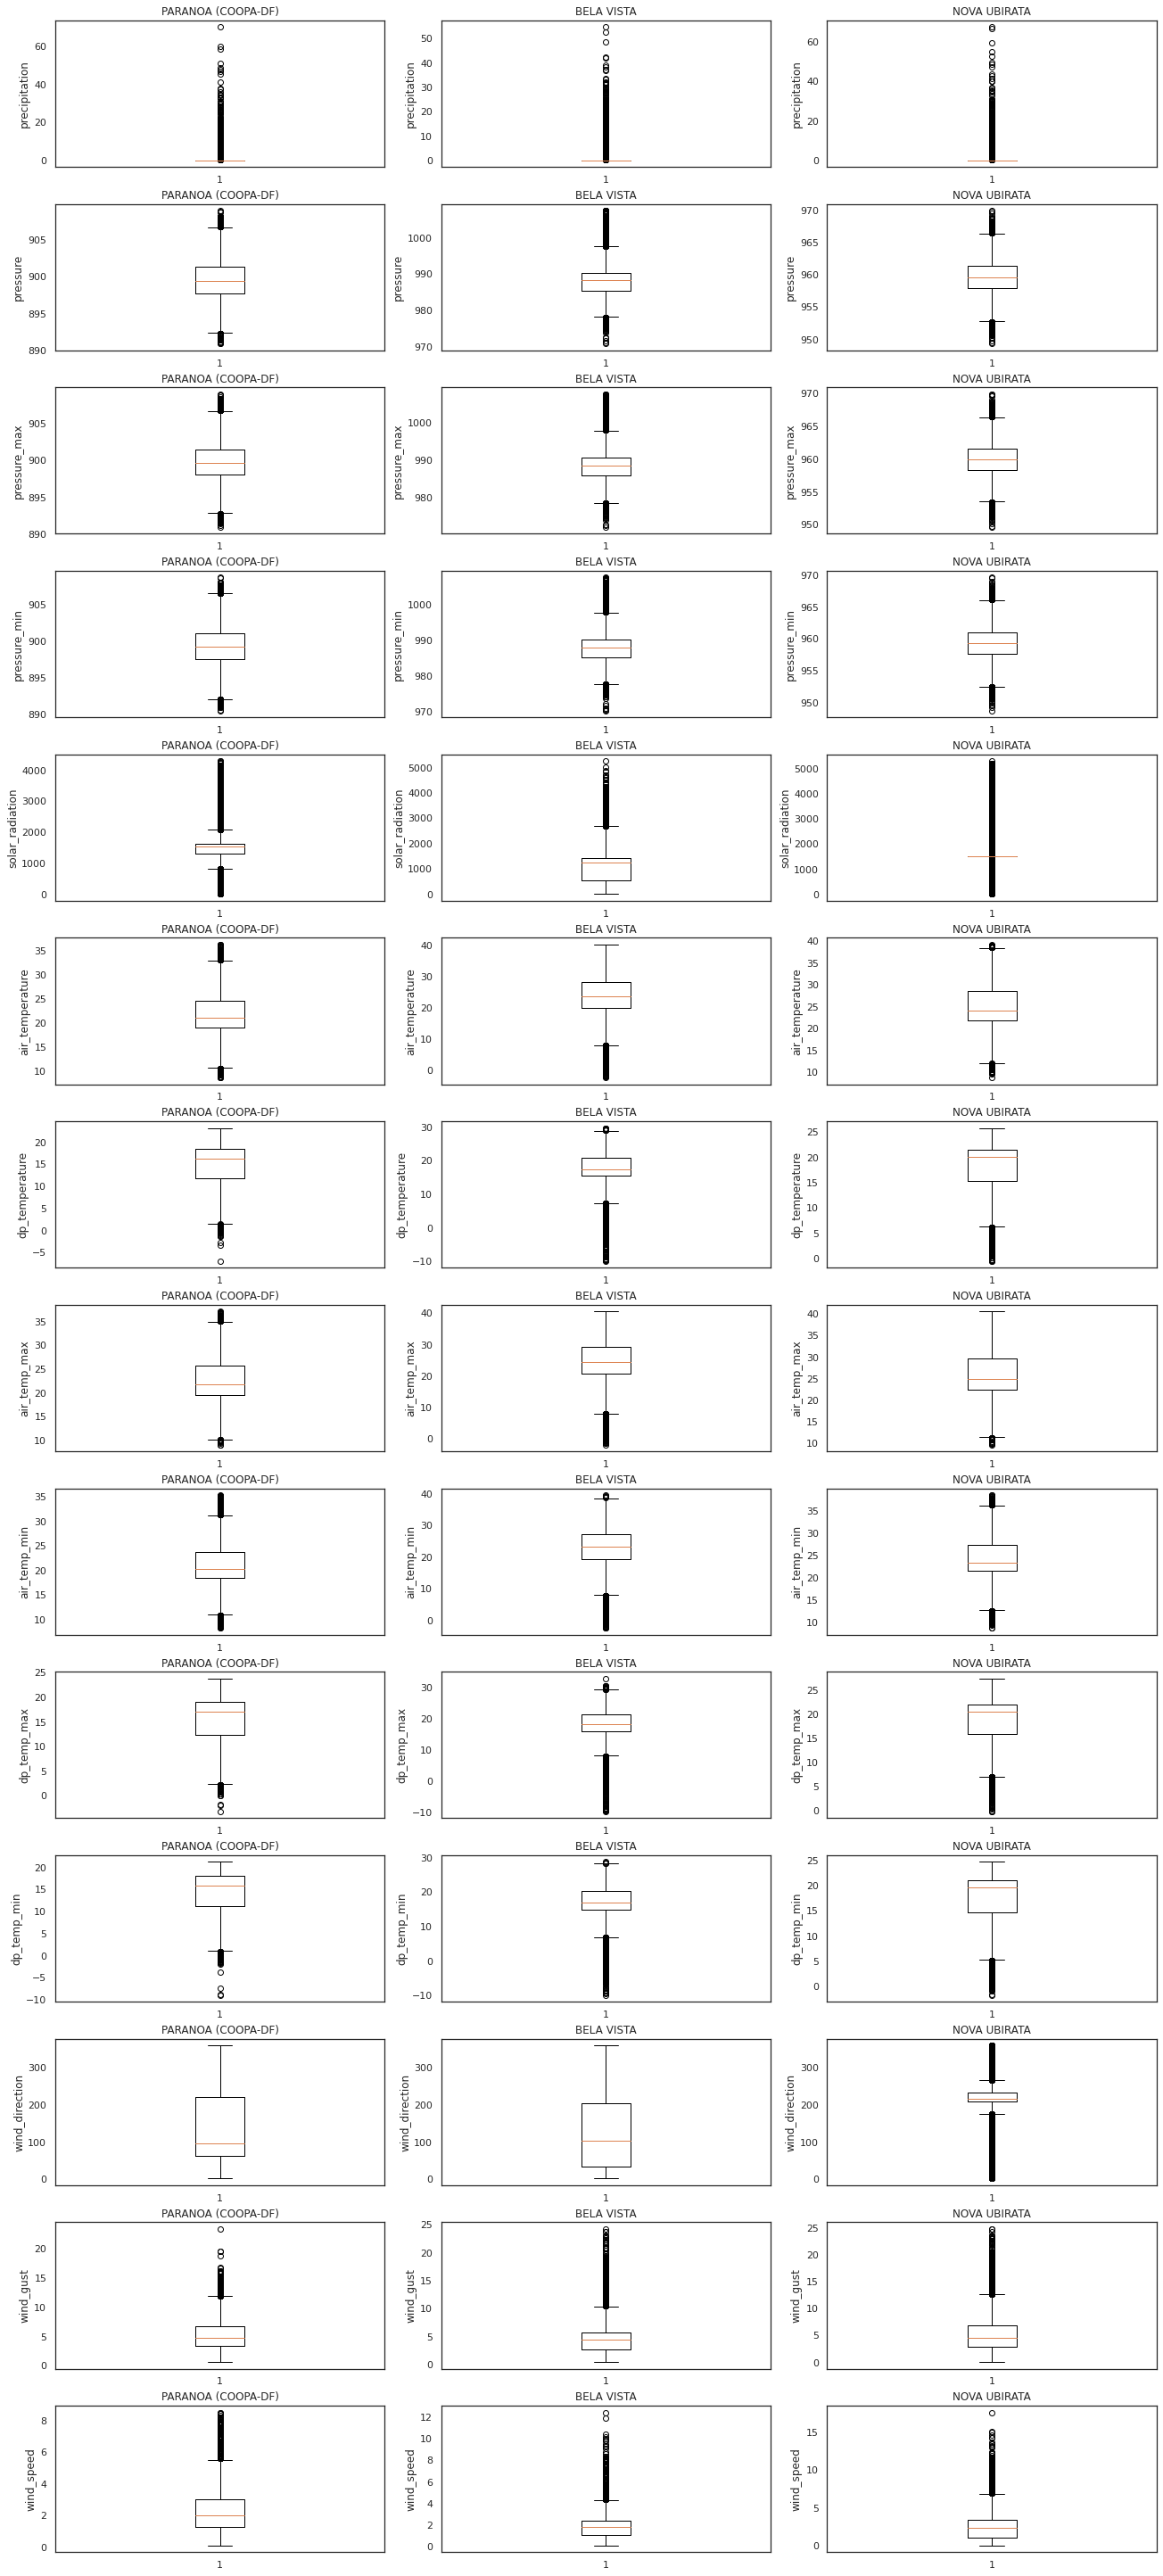

In [41]:
# grid of stations x features
fig, axs = plt.subplots(num_features, 
                        len(stations_picked), 
                        constrained_layout=True, 
                        figsize=(18, 40))

for i in range(0,num_features): # iterate features
    for j in range(0,len(stations_picked)): # iterate stations
#        print('station: ' + str(j) + ' ' + stations[j] + ', feature: ' + str(i) + ' ' + dataset.columns[feature_offset + i])
        axs[i,j].boxplot(x=dataset.loc[dataset.station_name == stations[j], dataset.columns[feature_offset + i]])
        axs[i,j].set_ylabel(dataset.columns[feature_offset + i])
        axs[i,j].set_title(stations[j])

We can see that there are many outliers (circles outside the moustaches) but the ranges are specific to each station.

Next will calculate the ranges of the outliers for each feature in each station.

**Warning:** In a real world application we  should not use values from the test dataset for outlier removal. However, in order to keep this exercise simple, we will ignore this and remove the outliers before spliting the dataset.

The outliers fall below **Q1 - 1.5 x IQR** or above **Q3 + 1.5 x IQR**.


```
     Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                  |-----:-----|
  o      |--------|     :     |--------|    o  o
                  |-----:-----|

outliers          <----------->            outliers
            inter-quartile range (IQR)

```

As we saw in the boxplots earlier, if we use the IQR to determine outliers, some features will have a very high number of 'outliers'. We will not do outlier removal on these features. As the objective of this exercise is not to focus on outlier removal, we will not implement alternatives for these features.

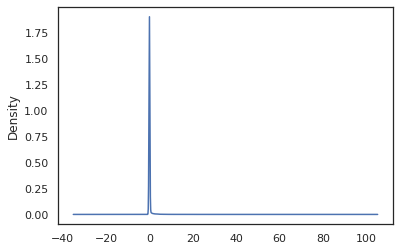

In [45]:
dataset.loc[dataset.station_name == 'PARANOA (COOPA-DF)'].precipitation.plot.kde();

Also note that wind_direction is in degrees, which rolls around in 360, so a specific strategy should be emplyed for this feature. 

In [46]:
# For each station, iterate through the numeric features and calculate 
# the lower and upper limits of the feature, and remove all measurements
# that fall outside those limits (i.e. outliers)

frames = []
num_features = 14
feature_offset = 1
stations = dataset['station_name'].unique().tolist() # list of stations

a = 1

# for each station
for i in stations:
    global outlier_free_index
    global outlier_free_df
    
    # create dataset with data of that station only
    df_station = dataset[dataset['station_name']== i].copy()
    
    print('processing station {} {}'.format(str(a), i), end='')
    a +=1
    
    # start with all data rows
    outlier_free_index = df_station.index
    previous_OFI_size = len(outlier_free_index)

    print(' with {} rows of data'.format(len(outlier_free_index)))
    
    # remove outliers of each feature form the outlier_free_index
    for j in range(feature_offset, feature_offset + num_features): # iterate features

        # skip outlier removal for features that don't have normal distribution)
        if j in [1, 2, 5, 7, 12, 13]:
            continue
        Q1, Q3 = np.percentile(df_station.iloc[:,j], [25, 75])
        IQR = Q3 - Q1
        # determine outlier fences
        minimum = Q1 - 1.5 * IQR
        maximum = Q3 + 1.5 * IQR
        
        print('{}: should be between {:.2f} and {:.2f}.'.format(dataset.columns[j], minimum, maximum), end='')
        
        # Keep only rows that are not outliers of this feature
        outlier_free_index = [x for x in outlier_free_index
                              if ((df_station.loc[x,df_station.columns[j]] >= minimum) &
                                  (df_station.loc[x,df_station.columns[j]] <= maximum))]
        
        original = len(df_station)
        current = len(outlier_free_index)
        
        print(" Removed {} outliers ({:.1f}%).".format(previous_OFI_size - current, 
                                                       (previous_OFI_size - current)/original*100))
        
        previous_OFI_size = len(outlier_free_index)

    # save frame with data from the station (without outliers)
    frames.append(df_station.loc[outlier_free_index])

    original = len(df_station)
    current = len(outlier_free_index)
    print("Removed {} outliers overall ({:.1f}%).\n".format(original - current, (original - current)/original*100))

processing station 1 PARANOA (COOPA-DF) with 36453 rows of data
pressure_max: should be between 892.75 and 906.75. Removed 187 outliers (0.5%).
pressure_min: should be between 892.10 and 906.50. Removed 3 outliers (0.0%).
air_temperature: should be between 10.60 and 33.00. Removed 210 outliers (0.6%).
air_temp_max: should be between 10.10 and 34.90. Removed 0 outliers (0.0%).
air_temp_min: should be between 10.85 and 31.25. Removed 204 outliers (0.6%).
dp_temp_max: should be between 2.25 and 29.05. Removed 35 outliers (0.1%).
dp_temp_min: should be between 1.00 and 28.20. Removed 20 outliers (0.1%).
wind_speed: should be between -1.25 and 5.55. Removed 622 outliers (1.7%).
Removed 1281 outliers overall (3.5%).

processing station 2 BELA VISTA with 77708 rows of data
pressure_max: should be between 978.35 and 997.95. Removed 2231 outliers (2.9%).
pressure_min: should be between 977.60 and 997.60. Removed 23 outliers (0.0%).
air_temperature: should be between 7.85 and 40.25. Removed 366 

air_temp_max: should be between 10.25 and 37.85. Removed 2 outliers (0.0%).
air_temp_min: should be between 10.90 and 34.10. Removed 547 outliers (0.5%).
dp_temp_max: should be between 0.50 and 30.90. Removed 270 outliers (0.3%).
dp_temp_min: should be between -1.00 and 30.20. Removed 50 outliers (0.0%).
wind_speed: should be between -2.55 and 5.85. Removed 1166 outliers (1.1%).
Removed 3128 outliers overall (3.0%).

processing station 13 APIACAS with 98811 rows of data
pressure_max: should be between 981.10 and 993.10. Removed 702 outliers (0.7%).
pressure_min: should be between 980.10 and 992.90. Removed 17 outliers (0.0%).
air_temperature: should be between 14.00 and 38.80. Removed 5 outliers (0.0%).
air_temp_max: should be between 13.10 and 41.10. Removed 0 outliers (0.0%).
air_temp_min: should be between 15.15 and 36.35. Removed 88 outliers (0.1%).
dp_temp_max: should be between 17.65 and 26.85. Removed 8423 outliers (8.5%).
dp_temp_min: should be between 16.35 and 26.35. Removed 

pressure_max: should be between 930.80 and 944.40. Removed 173 outliers (0.7%).
pressure_min: should be between 930.05 and 944.05. Removed 14 outliers (0.1%).
air_temperature: should be between 13.15 and 35.15. Removed 291 outliers (1.2%).
air_temp_max: should be between 12.50 and 37.30. Removed 0 outliers (0.0%).
air_temp_min: should be between 13.80 and 33.00. Removed 248 outliers (1.0%).
dp_temp_max: should be between 13.04 and 21.62. Removed 2669 outliers (11.2%).
dp_temp_min: should be between 11.97 and 20.34. Removed 435 outliers (1.8%).
wind_speed: should be between -1.80 and 7.00. Removed 233 outliers (1.0%).
Removed 4063 outliers overall (17.0%).

processing station 36 POSSE with 116336 rows of data
pressure_max: should be between 915.10 and 928.70. Removed 661 outliers (0.6%).
pressure_min: should be between 914.60 and 928.20. Removed 112 outliers (0.1%).
air_temperature: should be between 12.80 and 36.00. Removed 97 outliers (0.1%).
air_temp_max: should be between 12.85 and 

dp_temp_min: should be between 0.10 and 29.70. Removed 101 outliers (0.1%).
wind_speed: should be between -2.45 and 4.35. Removed 1986 outliers (1.8%).
Removed 3915 outliers overall (3.6%).

processing station 58 RIO BRILHANTE with 111849 rows of data
pressure_max: should be between 965.40 and 986.20. Removed 1034 outliers (0.9%).
pressure_min: should be between 964.65 and 985.85. Removed 25 outliers (0.0%).
air_temperature: should be between 8.30 and 38.70. Removed 965 outliers (0.9%).
air_temp_max: should be between 8.15 and 40.55. Removed 2 outliers (0.0%).
air_temp_min: should be between 8.30 and 37.10. Removed 441 outliers (0.4%).
dp_temp_max: should be between 7.45 and 29.45. Removed 1407 outliers (1.3%).
dp_temp_min: should be between 5.95 and 28.75. Removed 357 outliers (0.3%).
wind_speed: should be between -3.30 and 5.50. Removed 2079 outliers (1.9%).
Removed 6310 outliers overall (5.6%).

processing station 59 ALTO ARAGUAIA with 76858 rows of data
pressure_max: should be betw

air_temp_max: should be between 10.30 and 41.50. Removed 1 outliers (0.0%).
air_temp_min: should be between 9.70 and 39.30. Removed 46 outliers (0.2%).
dp_temp_max: should be between 5.45 and 32.25. Removed 67 outliers (0.3%).
dp_temp_min: should be between 4.20 and 31.40. Removed 12 outliers (0.1%).
wind_speed: should be between -1.05 and 4.95. Removed 579 outliers (2.7%).
Removed 1177 outliers overall (5.5%).

processing station 81 COSTA RICA with 72961 rows of data
pressure_max: should be between 924.85 and 939.65. Removed 601 outliers (0.8%).
pressure_min: should be between 924.10 and 939.30. Removed 30 outliers (0.0%).
air_temperature: should be between 10.30 and 36.70. Removed 392 outliers (0.5%).
air_temp_max: should be between 9.75 and 38.95. Removed 1 outliers (0.0%).
air_temp_min: should be between 11.10 and 34.30. Removed 454 outliers (0.6%).
dp_temp_max: should be between 3.10 and 30.30. Removed 592 outliers (0.8%).
dp_temp_min: should be between 1.60 and 29.60. Removed 106

pressure_min: should be between 975.10 and 992.70. Removed 1 outliers (0.0%).
air_temperature: should be between 14.40 and 33.60. Removed 850 outliers (4.8%).
air_temp_max: should be between 15.00 and 34.20. Removed 91 outliers (0.5%).
air_temp_min: should be between 13.70 and 32.90. Removed 78 outliers (0.4%).
dp_temp_max: should be between 11.95 and 28.35. Removed 286 outliers (1.6%).
dp_temp_min: should be between 10.70 and 28.30. Removed 21 outliers (0.1%).
wind_speed: should be between -0.90 and 3.10. Removed 841 outliers (4.8%).
Removed 2402 outliers overall (13.6%).

processing station 104 FATIMA DO SUL with 8540 rows of data
pressure_max: should be between 965.05 and 985.45. Removed 104 outliers (1.2%).
pressure_min: should be between 964.05 and 985.25. Removed 0 outliers (0.0%).
air_temperature: should be between 9.05 and 38.25. Removed 80 outliers (0.9%).
air_temp_max: should be between 9.05 and 39.85. Removed 0 outliers (0.0%).
air_temp_min: should be between 8.90 and 36.90.

dp_temp_max: should be between 13.95 and 28.75. Removed 1240 outliers (6.5%).
dp_temp_min: should be between 12.30 and 28.30. Removed 95 outliers (0.5%).
wind_speed: should be between -0.85 and 3.55. Removed 514 outliers (2.7%).
Removed 2400 outliers overall (12.6%).

processing station 115 SERRA NOVA DOURADA with 14126 rows of data
pressure_max: should be between 955.80 and 967.80. Removed 60 outliers (0.4%).
pressure_min: should be between 955.05 and 967.45. Removed 7 outliers (0.0%).
air_temperature: should be between 15.80 and 35.80. Removed 91 outliers (0.6%).
air_temp_max: should be between 15.45 and 37.45. Removed 4 outliers (0.0%).
air_temp_min: should be between 16.00 and 34.40. Removed 48 outliers (0.3%).
dp_temp_max: should be between 21.65 and 21.65. Removed 64 outliers (0.5%).
dp_temp_min: should be between 20.77 and 20.77. Removed 0 outliers (0.0%).
wind_speed: should be between -0.90 and 6.30. Removed 270 outliers (1.9%).
Removed 544 outliers overall (3.9%).



In [47]:
# recreate the dataset from the cleaned frames
dataset = pd.concat(frames)

In [48]:
print("{} outliers were removed from the dataset ({:.1f}%)".format(11427120-len(dataset), 1-(len(dataset)/11427120)))

2058300 outliers were removed from the dataset (0.2%)


In [49]:
pickle.dump(dataset, open("no_outliers_dataset.pkl", "wb"))